# Tier3 Classification Samples

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#export
from xview2comp.nb_02c import *

### Generate classification samples from Tier 3 data set

In [6]:
SOURCE = Path('data/tier3/images/')

In [7]:
fnames = get_image_files(SOURCE)
npreimgs = pre_img_fpaths(fnames)
nposimgs = [pre2post_fpath(o) for o in npreimgs]
nposlabs = [img2label_fpath(o) for o in nposimgs]

In [8]:
path_polyimgs = Path('data/tier3/classification_images')
path_csv = Path('class_labels_tier3.csv')
os.makedirs(path_polyimgs, exist_ok=True)

Takes about 40 minutes to generate classification samples from Tier 3 data set.

In [6]:
#generate_classification_train(nposimgs, nposlabs, path_polyimgs, path_csv)

In [7]:
df = pd.read_csv('class_labels_tier3.csv')

In [11]:
df.damage.value_counts()

no-damage        116209
minor-damage      10744
destroyed         10335
un-classified      8751
major-damage       7288
Name: damage, dtype: int64

### How many samples are there in each category (damage level)?

In [9]:
nsets = ['train', 'tier3']

In [10]:
csvnames = [f'class_labels_{o}.csv' for o in nsets]
annots = pd.concat([pd.read_csv(o) for o in csvnames], axis=0)

Looks like the uids under 'train' and 'tier3' do not overlap, so we can move all the images to the same directory, to keep things simple, if we want to.

In [11]:
annots.uid.unique().shape, annots.shape

((316114,), (316114, 2))

In [12]:
#export
def combine_nodamage_unclassified(annots):
    base_level = 'no-damage/un-classified'
    df = annots.copy()
    df.damage.replace('no-damage', base_level, inplace=True)
    df.damage.replace('un-classified', base_level, inplace=True)
    return df

In [13]:
annots = combine_nodamage_unclassified(annots)

It looks like the category 'no-damage/un-classified' has about ten times more samples than the other categories.

In [14]:
annots.damage.value_counts()

no-damage/un-classified    245379
minor-damage                25724
destroyed                   23562
major-damage                21449
Name: damage, dtype: int64

### Get all images' file name in a list

In [15]:
dirs = [Path('data')/o/'classification_images' for o in nsets]
fnames = [o_ for o in dirs for o_ in get_image_files(o)]

In [16]:
%%time
uids = [o.stem for o in fnames]

CPU times: user 260 ms, sys: 12 ms, total: 272 ms
Wall time: 271 ms


In [18]:
df_fnames = pd.DataFrame({'uid':uids, 'file':fnames})
print(df_fnames.shape)
df_fnames.head()

(316114, 2)


,uid,file
0,81c80fb6-b229-420c-9e4c-8fe32b126817,data/train/classification_images/81c80fb6-b229...
1,ee5059a0-b4c7-465d-a5cf-c31e2f015c1a,data/train/classification_images/ee5059a0-b4c7...
2,3b5f7043-9386-41ef-a3c7-ff5702d4622f,data/train/classification_images/3b5f7043-9386...
3,59646f2f-8085-4159-814a-840a01a69abf,data/train/classification_images/59646f2f-8085...
4,6fa1188a-af43-4c45-8398-27df8e1ea4ad,data/train/classification_images/6fa1188a-af43...


In [19]:
%%time
annots = pd.merge(annots, df_fnames, left_on='uid', right_on='uid', how='inner')

CPU times: user 332 ms, sys: 16 ms, total: 348 ms
Wall time: 474 ms


### Get area of image

In [20]:
#export
@property
def get_image_area(o):
    w, h = o.size
    return w * h

Image.area = get_image_area

In [21]:
%%time
annots['area'] = annots.file.apply(lambda o: open_image(o).area)

CPU times: user 9min 31s, sys: 40.3 s, total: 10min 11s
Wall time: 5min 38s


### Images' area distribution

Area is highly skewed.

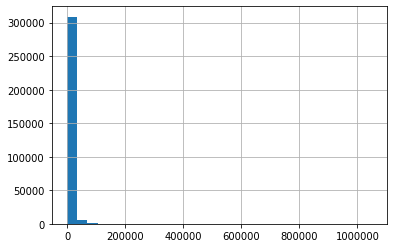

In [22]:
annots.area.hist(bins=30)

In [23]:
annots.area.describe()

count    3.161140e+05
mean     8.655772e+03
std      1.658701e+04
min      5.800000e+01
25%      2.310000e+03
50%      5.356000e+03
75%      1.050800e+04
max      1.048576e+06
Name: area, dtype: float64

#### Look at some of the largest images (by fractional area of the original image area)

In [24]:
sz_full = 1024**2

In [25]:
annots_frac1 = annots[annots.area > sz_full / 2**1]

In [26]:
annots_frac2 = annots[annots.area > sz_full / 2**2]

In [27]:
annots_frac3 = annots[annots.area > sz_full / 2**3]

In [28]:
annots_frac1.shape, annots_frac2.shape, annots_frac3.shape

((44, 4), (193, 4), (687, 4))

These do not look like a valid polygon image...  

* `annots_frac1`:  
* `annots_frac2`:  
* `annots_frac3`: 340

no-damage/un-classified


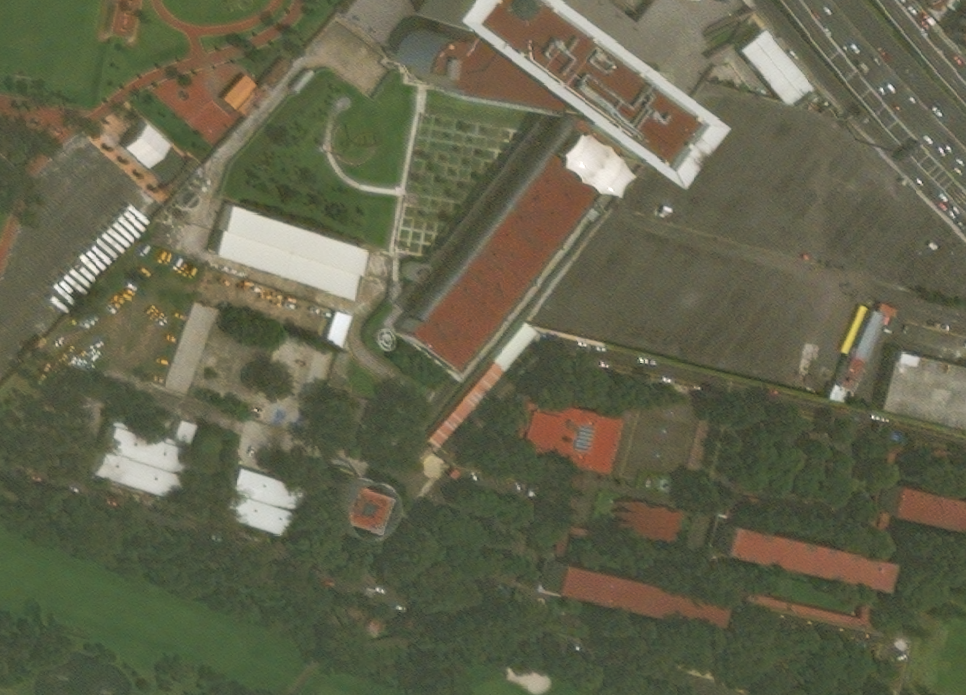

In [29]:
idx = 2
print(annots_frac1.iloc[idx].damage)
open_image(annots_frac1.iloc[idx].file)

### Get a balanced training set

There are many more 'no-damage/un-classified' images than others.

In [30]:
annots.damage.value_counts()

no-damage/un-classified    245379
minor-damage                25724
destroyed                   23562
major-damage                21449
Name: damage, dtype: int64

In [31]:
_damg_levels = ['minor-damage', 'major-damage', 'destroyed']

Reduce the `no-damage/un-classified` category to about the same size as the other categories.  Then, re-join it to the rest.

In [32]:
nkeep = int(annots.damage.value_counts().loc[_damg_levels].mean())
annots_undamg_subset = annots[annots.damage == 'no-damage/un-classified'].sample(nkeep)
annots_damg = annots[annots.damage.isin(_damg_levels)]

In [33]:
annots_trn = pd.concat([annots_damg, annots_undamg_subset], axis=0)

In [34]:
annots_trn.damage.value_counts()

minor-damage               25724
no-damage/un-classified    23578
destroyed                  23562
major-damage               21449
Name: damage, dtype: int64

Notice that the reduced set's quantiles agree quite well with the original set's.  

In [35]:
annots_trn.area.describe()

count    9.431300e+04
mean     8.822815e+03
std      1.709035e+04
min      7.000000e+01
25%      2.310000e+03
50%      5.520000e+03
75%      1.083600e+04
max      1.048576e+06
Name: area, dtype: float64

In [36]:
annots.area.describe()

count    3.161140e+05
mean     8.655772e+03
std      1.658701e+04
min      5.800000e+01
25%      2.310000e+03
50%      5.356000e+03
75%      1.050800e+04
max      1.048576e+06
Name: area, dtype: float64

However, we can also add in those very large images that are left out.

In [37]:
annots_xla = annots[annots.area > annots_trn.area.max()]

In [38]:
annots_trn = annots_trn.append(annots_xla)

Now it looks like we have a good range of image sizes, and balanced damage categories.

In [39]:
annots_trn.area.describe()

count    9.431300e+04
mean     8.822815e+03
std      1.709035e+04
min      7.000000e+01
25%      2.310000e+03
50%      5.520000e+03
75%      1.083600e+04
max      1.048576e+06
Name: area, dtype: float64

In [40]:
annots_trn.damage.value_counts()

minor-damage               25724
no-damage/un-classified    23578
destroyed                  23562
major-damage               21449
Name: damage, dtype: int64

In [41]:
annots_trn.to_csv('class_labels_combined_gpu.csv', index=False)

In [42]:
annots_trn.head()

,damage,uid,file,area
585,destroyed,94dc713b-fd48-4165-984d-d4b356094605,data/train/classification_images/94dc713b-fd48...,25160
586,destroyed,e5305648-ca70-4679-bd79-ff430ece9e9d,data/train/classification_images/e5305648-ca70...,9790
587,destroyed,5fb72361-a596-41cd-849b-35a590fd8bcf,data/train/classification_images/5fb72361-a596...,9396
588,destroyed,9506a448-92a6-4f5f-8370-bd4a91a6968f,data/train/classification_images/9506a448-92a6...,1275
589,destroyed,9180fca8-e572-49bb-a95e-bd4deb0d38ce,data/train/classification_images/9180fca8-e572...,2912


### Shorten damage level names

In [3]:
annots_trn = pd.read_csv('class_labels_combined_gpu.csv')

In [6]:
annots_trn.damage.value_counts()

minor-damage               25724
no-damage/un-classified    23578
destroyed                  23562
major-damage               21449
Name: damage, dtype: int64

In [7]:
_replace_dict = {'no-damage/un-classified':'nun', 'minor-damage':'minor', 'major-damage':'major'}

In [8]:
for t, v in _replace_dict.items():
    annots_trn['damage'] = annots_trn.damage.replace(to_replace=t, value=v)

In [10]:
annots_trn.damage.value_counts()

minor        25724
nun          23578
destroyed    23562
major        21449
Name: damage, dtype: int64

In [11]:
annots_trn.to_csv('class_labels_combined_gpu.csv', index=False)

# -fin

In [12]:
! python notebook2script.py 02d_tier3_classification_samples.ipynb

Converted 02d_tier3_classification_samples.ipynb to xview2comp/nb_02d.py
